<a href="https://colab.research.google.com/github/Jrk373/MachineLearningDemo/blob/main/DecisionTreeClasifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create Artificial Intelligence Using Decision Tree Classifiers

John Ryan Kivela, MA

Ventura, CA

# Introduction

This is a walkthrough demonstration of fundemental Machine Learning concepts and techniques used in developing Artificial Intelligence (AI).

The activity will create a Narrow Artificial Intelligence, called Clepy 1.0, who will tell us if an employee is likely to leave the company.

Narrow AI, also known as Weak AI, is a type of artificial intelligence designed to perform a specific task or solve a particular problem with high efficiency. Unlike General AI, Narrow AI is limited in scope and cannot adapt to tasks outside its predefined domain.

**Meet Clepy!**

Clepy is the misunderstood Gen Z granddaughter of fan favorite, Clippy. Clepy's domain is the ability to predict attrition based on employee characteristics.

She delivers answers, with attitude.

<img src="https://github.com/Jrk373/MachineLearningDemo/blob/main/narbgirlwip3.jpeg?raw=true" alt="Clepy" width="300" height="200" />

## Intended Audience

- The intended audience is a discerning group of professionals with strong data literacy, advanced education in mathematics like Central Limits Theorum (mean, median, mode, standard deviation, etc.), and basic Linear Algebra.

- It is not necessary to understand computer languages for this activity. This notebook primarily speaks in Python, but it is programmed to run all code and calculations out-of-the-box for any participant.

## Participant Objectives

- Understand the basic concept of Decision Tree Classifer models.
- Develop understanding of programming a decision tree with Python.
- Build a decision tree model algorythm for Clepy.
- Design and deploy a web application for Clepy's model.

## Enjoy!



# Method

## Materials

- This open source Python Notebook.
- Materials are located in a public Github repository.

  https://github.com/Jrk373/MachineLearningDemo

- This course requires participants to have a Google Account.

## CRISP-DM

CRISP-DM stands for Cross-Industry Standard Process for Data Mining. It's a popular method used to guide data mining and data science projects.

<img src="https://github.com/Jrk373/MachineLearningDemo/blob/main/crisp_process.jpg?raw=true" alt="Clepy" width="300" height="300" />



The process is divided into six main phases:

- **Business Understanding:** Understand the project's goals and requirements from a business perspective.
- **Data Understanding:** Collect and analyze the data to understand its characteristics.
- **Data Preparation:** Clean and prepare the data for analysis.
- **Modeling:** Apply different modeling techniques to the prepared data.
- **Evaluation:** Assess the models to ensure they meet the business objectives.
- **Deployment:** Implement the model in the real-world environment and monitor its performance.

## Object Oriented Programming

Object-Oriented Programming is a way of organizing code using objects, which represent real-world things with data and methods.

The three key features of Object-Oriented Programming are **Encapsulation**, **Inheritance**, and **Polymorphism**. Below is a description of each feature along with corresponding Python code snippets.

## Encapsulation

Encapsulation is the bundling of data (attributes) and methods (functions) that operate on the data into a single unit or class.

Example Code:

```python
account = BankAccount()
account.deposit(100)
print(account.get_balance())  # Output: 100
```

## Inheritance

Inheritance allows a class to inherit attributes and methods from another class, promoting code reusability and establishing a relationship between classes.

Example Code:

```python
dog = Dog()
print(dog.speak())   # Output: Bark
print(isinstance(dog, Animal))  # Output: True (Dog is an Animal)
```

## Polymorphism

Polymorphism allows the same methods to do different things based on the object it is acting upon.

Example Code:

```python
dog = Dog()
cat = Cat()

animal_sound(dog)   # Output: Bark
animal_sound(cat)   # Output: Meow
```

## Python

Python is an object oreiented programming language known for its simplicity and readability. It is widely used for web development, data analysis, machine learning, automation, scientific computing, and more. Python's philosophy emphasizes easy-to-understand syntax that allows developers to express concepts with brevity and explain to business teams.

## Jupyter Notebooks

Jupyter Notebooks are an open-source, interactive computing environment that allows users to create and share documents containing live code, equations, visualizations, and narrative text. They are widely used in data science, machine learning, academic research, and scientific computing due to their versatility and ease of use.

## Resources

The notebook is inspired by the ODSC West 2024 AI Bootcamp and Statquest Classification Trees in Python. This notebook partners with AI like ChatGPT and Gemini as generators of code and content.



# Procedure

The instructor will walk through the Notebook with the audience watching and discussing. Then the instructor and the class go through the notebook together. The learner can then go on to use the Notebook on their own.

## Stage 1: Business Understanding

The Business Understanding phase of CRISP-DM focuses on defining the project’s goals and objectives from a business perspective. This stage ensures that the data science work aligns with the organization’s needs and delivers value.

This is the most important step to building a product that will meet the business needs of the company.

Ironically, we will spend very little time on it for this presentation.

## Stage 2: Data Understanding

The Data Understanding phase of the CRISP-DM (Cross-Industry Standard Process for Data Mining) framework focuses on exploring and analyzing the available data to ensure it is suitable for the project's goals.

It involves the following steps:

- **Data Collection:** Gather initial data from relevant sources.

- **Data Description:** Summarize key attributes, including data types, formats, and basic statistics (e.g., means, counts, ranges).

- **Data Exploration:** Use visualizations and analyses to identify patterns, trends, or potential relationships in the data.

- **Data Quality Assessment:** Check for issues such as missing values, outliers, inconsistencies, or inaccuracies.
The objective is to develop insights into the data, identify challenges, and determine whether it can support the project's objectives effectively.

### Data Set

The **Employee Attrition for Healthcare Dataset** is a dataset used to analyze and predict employee turnover (attrition) within healthcare organizations. Attrition in this context indicates the rate at which employees leave their jobs, whether voluntarily (resignation, retirement) or involuntarily (termination).

https://www.kaggle.com/datasets/jpmiller/employee-attrition-for-healthcare

Understanding and managing employee attrition is crucial in the healthcare sector, where staff shortages can directly impact patient care.

In [1]:
import urllib.request
import pandas as pd  # Importing pandas for handling dataframes

# Corrected URL with raw content
url = 'https://raw.githubusercontent.com/Jrk373/MachineLearningDemo/main/watson_healthcare_modified.csv'
file_path = 'watson_healthcare_modified.csv'

# Retrieve the file
urllib.request.urlretrieve(url, file_path)

# Load the dataset
try:
    df = pd.read_csv(file_path)
    print('Successfully downloaded', file_path)
    print('Data successfully loaded as data frame "df"')
except pd.errors.ParserError as e:
    print("ParserError encountered:", e)
    print("Attempting to load with alternative options...")
    # Suppress warnings for error_bad_lines (deprecated since pandas v1.3.0)
    df = pd.read_csv(file_path, delimiter=',', on_bad_lines='skip')
    print("Data loaded with error handling.")


Successfully downloaded watson_healthcare_modified.csv
Data successfully loaded as data frame "df"


### Data Dictionary

**Employee Attrition for Healthcare Dataset - Data Dictionary**

https://github.com/Jrk373/MachineLearningDemo/blob/main/watson_healthcare_modified.csv

This document provides a detailed data dictionary for the "Employee Attrition for Healthcare" dataset available on Kaggle.

| **Column Name**             | **Data Type** | **Description**                                                                 |
|-----------------------------|---------------|---------------------------------------------------------------------------------|
| **Age**                     | Integer       | Age of the employee.                                                           |
| **Attrition**               | String        | Whether the employee has left the company ('Yes' or 'No').                     |
| **BusinessTravel**          | String        | Frequency of business travel ('Non-Travel', 'Travel_Rarely', 'Travel_Frequently'). |
| **DailyRate**               | Integer       | Daily rate of the employee.                                                    |
| **Department**              | String        | Department where the employee works.                                           |
| **DistanceFromHome**        | Integer       | Distance from home to workplace (in miles).                                    |
| **Education**               | Integer       | Education level (1: 'Below College', 2: 'College', 3: 'Bachelor', 4: 'Master', 5: 'Doctor'). |
| **EducationField**          | String        | Field of education.                                                            |
| **EmployeeCount**           | Integer       | Number of employees (default is 1 for each record).                            |
| **EmployeeNumber**          | Integer       | Unique identifier for each employee.                                           |
| **EnvironmentSatisfaction** | Integer       | Satisfaction with the environment (1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'). |
| **Gender**                  | String        | Gender of the employee ('Male' or 'Female').                                   |
| **HourlyRate**              | Integer       | Hourly rate of the employee.                                                   |
| **JobInvolvement**          | Integer       | Level of job involvement (1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High').   |
| **JobLevel**                | Integer       | Job level within the organization.                                             |
| **JobRole**                 | String        | Role of the employee within the company.                                       |
| **JobSatisfaction**         | Integer       | Job satisfaction level (1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High').     |
| **MaritalStatus**           | String        | Marital status of the employee.                                                |
| **MonthlyIncome**           | Integer       | Monthly income of the employee.                                                |
| **MonthlyRate**             | Integer       | Monthly rate of the employee.                                                  |
| **NumCompaniesWorked**      | Integer       | Number of companies the employee has worked for.                               |
| **Over18**                  | String        | Whether the employee is over 18 years old ('Yes').                             |
| **OverTime**                | String        | Whether the employee works overtime ('Yes' or 'No').                           |
| **PercentSalaryHike**       | Integer       | Percentage increase in salary.                                                 |
| **PerformanceRating**       | Integer       | Performance rating (1: 'Low', 2: 'Good', 3: 'Excellent', 4: 'Outstanding').    |
| **RelationshipSatisfaction**| Integer       | Satisfaction with relationships (1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'). |
| **StandardHours**           | Integer       | Standard working hours (default is 80).                                        |
| **StockOptionLevel**        | Integer       | Stock option level.                                                            |
| **TotalWorkingYears**       | Integer       | Total number of years the employee has worked.                                 |
| **TrainingTimesLastYear**   | Integer       | Number of training sessions attended last year.                                |
| **WorkLifeBalance**         | Integer       | Work-life balance rating (1: 'Bad', 2: 'Good', 3: 'Better', 4: 'Best').        |
| **YearsAtCompany**          | Integer       | Number of years the employee has been with the company.                        |
| **YearsInCurrentRole**      | Integer       | Number of years in the current role.                                           |
| **YearsSinceLastPromotion** | Integer       | Number of years since the last promotion.                                      |
| **YearsWithCurrManager**    | Integer       | Number of years with the current manager.                                      |

---

**Sources**

- Dataset: [Employee Attrition for Healthcare](https://www.kaggle.com/datasets/jpmiller/employee-attrition-for-healthcare)
- Data Dictionary: Compiled from the dataset's description and metadata.

### Data Shape

Assessing the shape of data helps identify its dimensionality (rows and columns), which is crucial for understanding its structure and determining suitable analysis techniques. It ensures the dataset is in the expected format, enabling error detection and proper preprocessing. Additionally, knowing the data shape aids in resource optimization and selecting the right tools for analysis.

In [2]:
# Import necessary packages
import pandas as pd

# Check the shape (rows, columns)
print('Data set rows and columns:', df.shape)

Data set rows and columns: (1676, 35)


In [3]:
# Import necessary packages
import pandas as pd
from tabulate import tabulate

# Print off the first 5 rows in a visually appealing table format
print(tabulate(df.head(5), headers='keys', tablefmt='pretty'))

+---+------------+-----+-----------+-------------------+-----------+------------+------------------+-----------+----------------+---------------+-------------------------+--------+------------+----------------+----------+---------+-----------------+---------------+---------------+-------------+--------------------+--------+----------+-------------------+-------------------+--------------------------+---------------+-------+-------------------+-----------------------+-----------------+----------------+--------------------+-------------------------+----------------------+
|   | EmployeeID | Age | Attrition |  BusinessTravel   | DailyRate | Department | DistanceFromHome | Education | EducationField | EmployeeCount | EnvironmentSatisfaction | Gender | HourlyRate | JobInvolvement | JobLevel | JobRole | JobSatisfaction | MaritalStatus | MonthlyIncome | MonthlyRate | NumCompaniesWorked | Over18 | OverTime | PercentSalaryHike | PerformanceRating | RelationshipSatisfaction | StandardHours | Shi

In [4]:
# Import necessary packages
import pandas as pd

# Lets get more basic information on columns, datatypes etc using .info()
print('Feature Information:')
print('-' * 40)
print(df.info())

Feature Information:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1676 entries, 0 to 1675
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   EmployeeID                1676 non-null   int64 
 1   Age                       1676 non-null   int64 
 2   Attrition                 1676 non-null   object
 3   BusinessTravel            1676 non-null   object
 4   DailyRate                 1676 non-null   int64 
 5   Department                1676 non-null   object
 6   DistanceFromHome          1676 non-null   int64 
 7   Education                 1676 non-null   int64 
 8   EducationField            1676 non-null   object
 9   EmployeeCount             1676 non-null   int64 
 10  EnvironmentSatisfaction   1676 non-null   int64 
 11  Gender                    1676 non-null   object
 12  HourlyRate                1676 non-null   int64 
 13  JobInvolvement  

## Stage 3: Data Preparation

### Unnecessary columns

Decision trees can grow unnecessarily large as they attempt to evaluate splits based on irrelevant columns.

Irrelevant features increase the model's complexity without improving accuracy, making the tree harder to interpret.

The model might perform well on training data but poorly on validation or test data.

In [5]:
# Columns to drop
columns_to_drop = ['EmployeeID',
                   'StandardHours',
                   'Over18',
                   'MonthlyRate',
                   'EmployeeCount']

# Drop the columns like they are hot
try:
    df = df.drop(columns=columns_to_drop)
    print(f"Successfully dropped columns: {columns_to_drop}")
except KeyError as e:
    print(f"KeyError encountered: {e}")
    print("Please ensure the specified columns exist in the DataFrame.")

Successfully dropped columns: ['EmployeeID', 'StandardHours', 'Over18', 'MonthlyRate', 'EmployeeCount']


### Missing Values

Decision trees do not inherently handle missing values, and failing to address them can negatively affect the model's performance.

 Null values can introduce noise, leading to incorrect or suboptimal splits.

 Splitting decisions may become less reliable or fail entirely if null values are not handled.



Null Values

In [6]:
import pandas as pd

# NULL Valuse

# Function to find columns with NaN values
def find_columns_with_nan(df):
    columns_with_nan = [col for col in df.columns if df[col].isna().any()]
    return columns_with_nan

# Identify variables with NaN values
columns_with_nan = find_columns_with_nan(df)

if columns_with_nan:
    print("Columns with NaN values:", columns_with_nan)
else:
    print("There are no NaN values in the dataset.")


There are no NaN values in the dataset.


Blank Values

In [7]:
import pandas as pd  # Importing pandas to handle DataFrames

# Missing Values / Blank Values

# Identifying missing values in the dataset
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]  # Filter out columns with no missing values

if missing_values.empty:
    print("There are no missing values in the dataset.")
else:
    print("Missing values by column:")
    print(missing_values)

    # Replacing missing values
    for column in df.columns:
        if df[column].isnull().any():  # Check if the column has missing values
            if df[column].dtype == 'object':  # For object (categorical) columns
                mode_value = df[column].mode()[0]
                df[column].fillna(mode_value, inplace=True)
                print(f"Missing values in column '{column}' replaced with mode: {mode_value}")
            elif df[column].dtype in ['float64', 'int64']:  # For numeric columns
                mean_value = df[column].mean()
                df[column].fillna(mean_value, inplace=True)
                print(f"Missing values in column '{column}' replaced with mean: {mean_value:.2f}")


There are no missing values in the dataset.


### Split **X** Feature Variables from **Y** Target Variable

At this point, we are confident that the data in our data frame is clean and tidy. This is the data set that the rest of the model will be based on.

We can now go ahead and split the Target Feature away from the data set.

In [8]:
import pandas as pd  # For handling DataFrames

# Split data to Target and Feature
Target = 'Attrition'

# Make a new copy of the columns used to make predictions
X = df.drop(Target, axis=1).copy()  # Alternatively: X = df_no_missing.iloc[:, :-1]

# Make a new copy of the column of data we want to predict
y = df[Target].copy()

# Check the shape of X and y
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# If the number of samples is different, raise an error
if X.shape[0] != y.shape[0]:
    raise ValueError("X and y must have the same number of samples.")

Shape of X: (1676, 29)
Shape of y: (1676,)


### Variable Encoding

#### Categorical Variables

Machine learning algorithms require numerical inputs to process data. Raw categorical data, like text or labels, cannot be directly used in calculations, and improper encoding might lead to misinterpretation.

Encoding methods like one-hot encoding for nominal data or label encoding for ordinal data ensure compatibility with algorithms and improve model performance.

In [9]:
# Import necessary packages
import pandas as pd
import numpy as np

# Identify categorical columns - assuming they are of type 'object'
categorical_columns = X.select_dtypes(include=['object']).columns

## Print the shape to see how many new columns we have before updating
print(f"Shape before encoding: {X.shape}")

# Print unique values for each categorical column before encoding
print("Unique values in categorical columns before one-hot encoding:")
for column in categorical_columns:
    print(f"{column}: {df[column].unique()}")

Shape before encoding: (1676, 29)
Unique values in categorical columns before one-hot encoding:
BusinessTravel: ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
Department: ['Cardiology' 'Maternity' 'Neurology']
EducationField: ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
Gender: ['Female' 'Male']
JobRole: ['Nurse' 'Other' 'Therapist' 'Administrative' 'Admin']
MaritalStatus: ['Single' 'Married' 'Divorced']
OverTime: ['Yes' 'No']


##### One-hot Encoding

One-hot encoding is a method to transform categorical data into a numerical format suitable for machine learning algorithms. It converts each category into a binary vector where only one element is "1" (indicating the presence of a specific category) and the rest are "0". For example, a feature with categories ["Apple", "Chicken", "Broccoli"] would be transformed into three binary columns: [1, 0, 0] for "Apple", [0, 1, 0] for "Chicken", and [0, 0, 1] for "Broccoli". This technique ensures no ordinal relationship is implied between categories and is widely used for nominal data.

<img src="https://github.com/Jrk373/MachineLearningDemo/blob/main/OneHotDiagram.jpg?raw=true" alt="OneHotDiagram" width="500" height="175" />

In [10]:
# Import necessary packages
import pandas as pd
import numpy as np

# Apply one-hot encoding to all categorical variables
df_encoded = pd.get_dummies(X)

In [11]:
# Import necessary packages
import pandas as pd
import numpy as np

## Print the shape to see how many new columns were added
print(f"Shape after encoding: {df_encoded.shape}")
print('-' * 40)

# Identify new one-hot encoded columns
new_columns = [col for col in df_encoded.columns if col not in df.columns]

# Print unique values in the new one-hot encoded columns (they should only be 0 or 1)
print("\nUnique values in one-hot encoded columns:")
for column in new_columns:
    print(f"{column}: {df_encoded[column].unique()}")

Shape after encoding: (1676, 46)
----------------------------------------

Unique values in one-hot encoded columns:
BusinessTravel_Non-Travel: [False  True]
BusinessTravel_Travel_Frequently: [False  True]
BusinessTravel_Travel_Rarely: [ True False]
Department_Cardiology: [ True False]
Department_Maternity: [False  True]
Department_Neurology: [False  True]
EducationField_Human Resources: [False  True]
EducationField_Life Sciences: [ True False]
EducationField_Marketing: [False  True]
EducationField_Medical: [False  True]
EducationField_Other: [False  True]
EducationField_Technical Degree: [False  True]
Gender_Female: [ True False]
Gender_Male: [False  True]
JobRole_Admin: [False  True]
JobRole_Administrative: [False  True]
JobRole_Nurse: [ True False]
JobRole_Other: [False  True]
JobRole_Therapist: [False  True]
MaritalStatus_Divorced: [False  True]
MaritalStatus_Married: [False  True]
MaritalStatus_Single: [ True False]
OverTime_No: [False  True]
OverTime_Yes: [ True False]


In [12]:
import pandas as pd  # For handling DataFrames

# Count of each data type, including 0 counts
data_type_counts = {dtype: (df_encoded.dtypes == dtype).sum() for dtype in ["bool", "category", "datetime64[ns]", "float64", "int64", "object", "str"]}

# Print the data type counts
print("Data type counts (including 0 values):")
for dtype, count in data_type_counts.items():
    print(f"{dtype}: {count}")

Data type counts (including 0 values):
bool: 24
category: 0
datetime64[ns]: 0
float64: 0
int64: 22
object: 0
str: 0


#### Boolean Variables

In [13]:
import pandas as pd  # For handling DataFrames

# Check for boolean columns and convert them to integers
bool_columns = df_encoded.select_dtypes(include=["bool"]).columns
for col in bool_columns:
    df_encoded[col] = df_encoded[col].astype(int)

# Check for object columns in the DataFrame
object_columns = df_encoded.select_dtypes(include=["object"]).columns

# Convert object columns to integers using Label Encoding
for col in object_columns:
    df_encoded[col] = df_encoded[col].astype("category").cat.codes

# Count of each data type, including 0 counts
data_type_counts = {dtype: (df_encoded.dtypes == dtype).sum() for dtype in ["bool", "category", "datetime64[ns]", "float64", "int64", "object"]}
data_type_counts = {k: v for k, v in sorted(data_type_counts.items())}  # Sort for clarity

# Print the data type counts
print("Data type counts (including 0 values):")
for dtype, count in data_type_counts.items():
    print(f"{dtype}: {count}")



Data type counts (including 0 values):
bool: 0
category: 0
datetime64[ns]: 0
float64: 0
int64: 46
object: 0


#### Target Variable

In [14]:
import pandas as pd  # For handling DataFrames

# Print unique values of the target variable before encoding
print('Unique y values before encoding:')
print(y.unique())

Unique y values before encoding:
['No' 'Yes']


In [15]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Get unique values
unique_values = np.unique(y_encoded)
print('Unique y values after encoding:')
print(unique_values)

Unique y values after encoding:
[0 1]


write to file

### Visualize Data

Review the data set that we have created by modifying the raw data.


#### X_encoded Data Frame

This is the X training data set for the model.

In [16]:
import pandas as pd

# Assign df_encoded to X_encoded for clarity
X_encoded = df_encoded

# Create a DataFrame to store unique values
unique_values_df = pd.DataFrame(columns=['Column', 'Unique Values'])

# Iterate through columns and add unique values to the DataFrame
for col in X_encoded.columns:
    unique_values_df = pd.concat([unique_values_df, pd.DataFrame({'Column': [col], 'Unique Values': [X_encoded[col].unique()]})], ignore_index=True)

## Print the shape to see how many new columns were added
print(f"Shape after encoding: {X_encoded.shape}")
print('-' * 40)

# Display the DataFrame with styling
unique_values_df.style.set_properties(**{'text-align': 'left'}) \
                      .set_table_styles([dict(selector='th', props=[('text-align', 'left')])])



Shape after encoding: (1676, 46)
----------------------------------------


#### Continuous Numbers

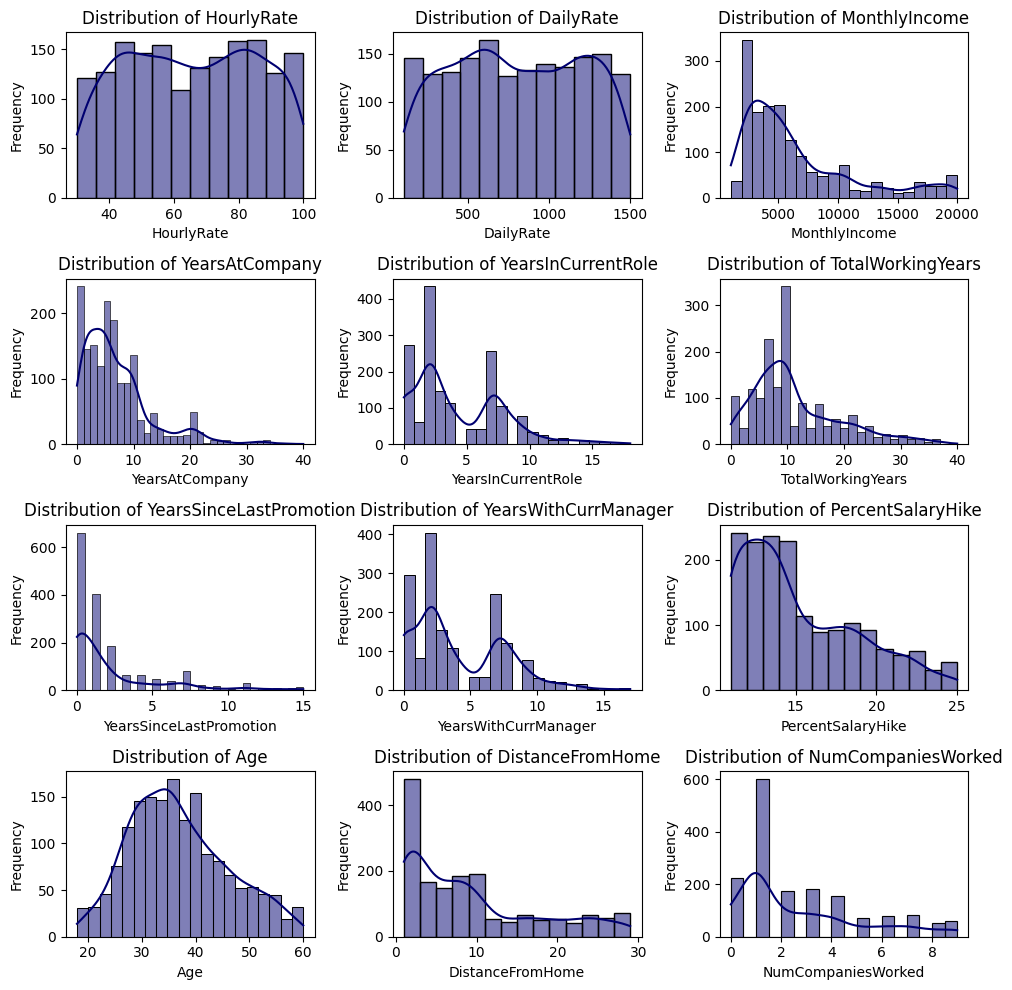

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# List of features to plot
features = [
    "HourlyRate",
    "DailyRate",
    "MonthlyIncome",
    "YearsAtCompany",
    "YearsInCurrentRole",
    "TotalWorkingYears",
    "YearsSinceLastPromotion",
    "YearsWithCurrManager",
    "PercentSalaryHike",
    'Age',
    'DistanceFromHome',
    'NumCompaniesWorked'
]

# Create a grid of plots
n_features = len(features)
cols = 3
rows = (n_features // cols) + (n_features % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(10, 2.5 * rows))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(X_encoded[feature], kde=True, ax=axes[i], color="#000070")
    axes[i].set_title(f"Distribution of {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Frequency")

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### Discrete NUmbers

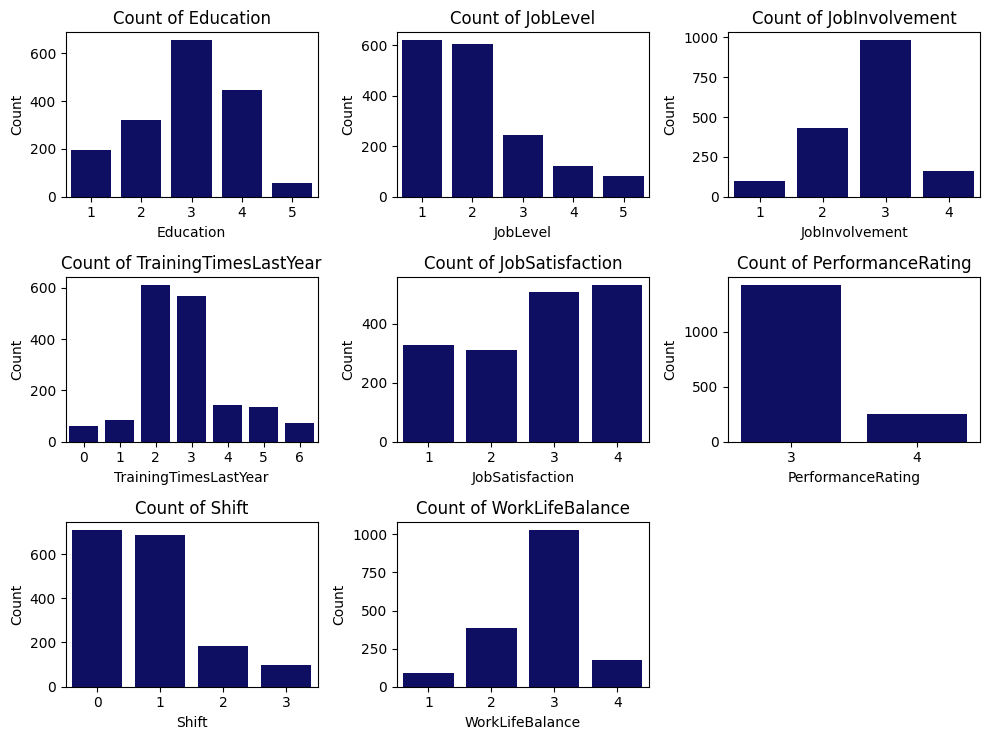

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# List of features to plot
features = ['Education',
            'JobLevel',
            'JobInvolvement',
            'TrainingTimesLastYear',
            'JobSatisfaction',
            'PerformanceRating',
            'Shift',
            'WorkLifeBalance']

# Create a grid of plots
n_features = len(features)
cols = 3
rows = (n_features // cols) + (n_features % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(10, 2.5 * rows))
axes = axes.flatten()

for i, feature in enumerate(features):
    # Use count plots to better display ordinal variables
    sns.countplot(x=X_encoded[feature], ax=axes[i], color="#000070")
    axes[i].set_title(f"Count of {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Count")

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### One-hot Encoded Variables

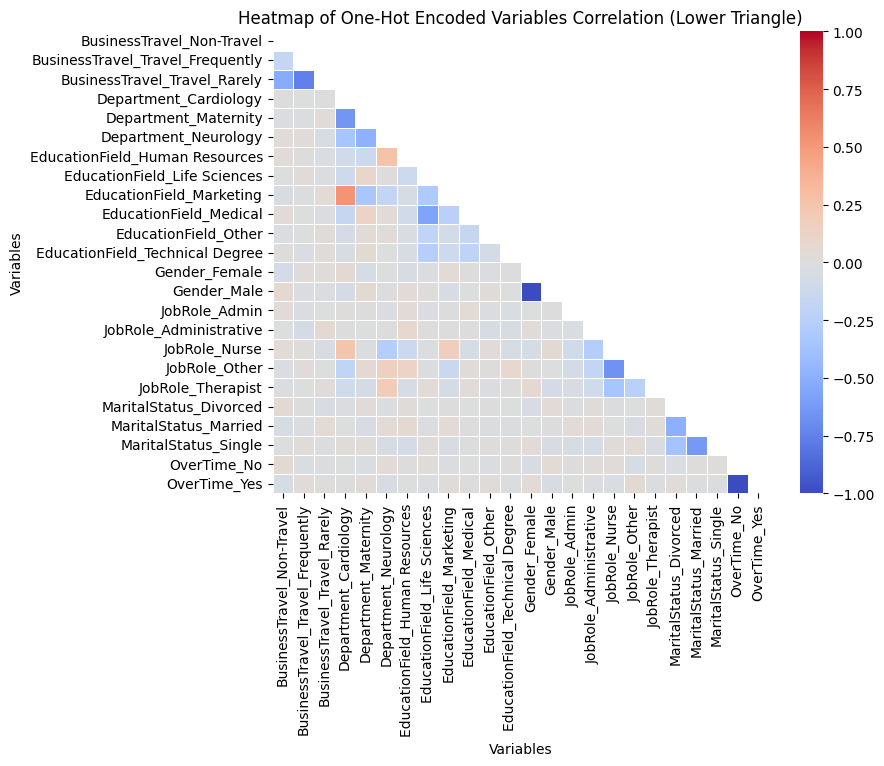

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# List of specific one-hot encoded variables to select
variables = [
    "BusinessTravel_Non-Travel", "BusinessTravel_Travel_Frequently", "BusinessTravel_Travel_Rarely",
    "Department_Cardiology", "Department_Maternity", "Department_Neurology",
    "EducationField_Human Resources", "EducationField_Life Sciences", "EducationField_Marketing",
    "EducationField_Medical", "EducationField_Other", "EducationField_Technical Degree",
    "Gender_Female", "Gender_Male",
    "JobRole_Admin", "JobRole_Administrative", "JobRole_Nurse", "JobRole_Other", "JobRole_Therapist",
    "MaritalStatus_Divorced", "MaritalStatus_Married", "MaritalStatus_Single",
    "OverTime_No", "OverTime_Yes"
]

# Filter the DataFrame to include only the specified variables
X_encoded_OneHot = X_encoded[variables]

# Calculate the correlation matrix for one-hot encoded variables
correlation_matrix = X_encoded_OneHot.corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the heatmap with the mask applied
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=False,
    cmap="coolwarm",
    linewidths=0.5,
    vmin=-1,  # Set the minimum value of the heatmap
    vmax=1    # Set the maximum value of the heatmap
)
plt.title("Heatmap of One-Hot Encoded Variables Correlation (Lower Triangle)")
plt.xlabel("Variables")
plt.ylabel("Variables")
plt.show()


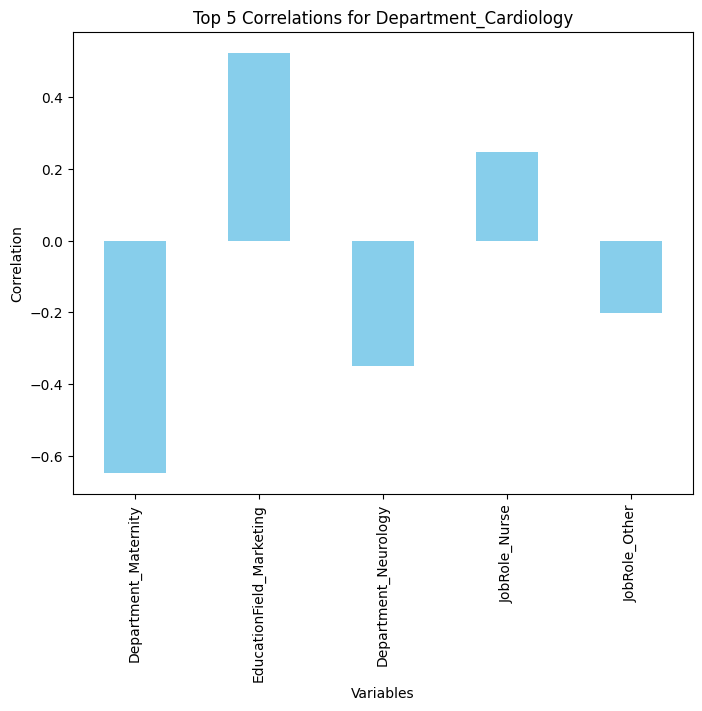

In [20]:
top_n = 5  # Number of top correlations to show
variable = "Department_Cardiology"  # Example variable to focus on

# Get top correlations for the selected variable
top_correlations = correlation_matrix[variable].sort_values(key=abs, ascending=False)[1:top_n + 1]

# Plot the bar chart
top_correlations.plot(kind="bar", color="skyblue", figsize=(8, 6))
plt.title(f"Top {top_n} Correlations for {variable}")
plt.ylabel("Correlation")
plt.xlabel("Variables")
plt.show()

#### Y_encoded Data Frame

This is the Y training data set for the model.

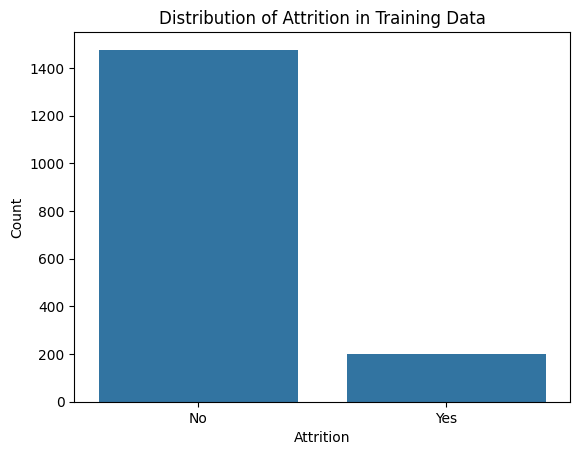

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_train contains the target variable (Attrition) for the training data

# Create a countplot
sns.countplot(x=y_encoded)

# Set labels and title
plt.xlabel("Attrition")
plt.ylabel("Count")
plt.title("Distribution of Attrition in Training Data")

# Customize plot appearance (optional)
plt.xticks([0, 1], ['No', 'Yes'])  # Replace 0 and 1 with your actual labels if different

# Display the plot
plt.show()

## Stage 4: Modeling

The modeling phase of CRISP-DM (Cross-Industry Standard Process for Data Mining) involves selecting and applying appropriate machine learning or statistical models to address the business problem. It includes tasks such as choosing suitable algorithms, tuning model parameters, and training models on the prepared dataset. This phase also involves evaluating multiple models to identify the one that performs best based on predefined metrics, ensuring it aligns with the project's goals. The results from this phase provide insights into the data and form the basis for deploying a solution.

The first parts of this process will be determineng correlations and importnace. We may need to return to shaping to scale variables if needed.

### Train Test Split

Train-test split is a common method used in machine learning to evaluate the performance of a model. It involves dividing a dataset into two subsets: one for training the model (the training set) and one for testing its performance (the test set). This ensures that the model is evaluated on data it has not seen before, providing an unbiased assessment of its ability to generalize to new data.

In [22]:
import pandas as pd  # For handling DataFrames
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=373)

# Confirming the split was successful
if len(X_train) + len(X_test) == len(X_encoded) and len(y_train) + len(y_test) == len(y_encoded):
    print("Data split successful!")
    print(f"Training set size: {len(X_train)} samples")
    print(f"Testing set size: {len(X_test)} samples")
else:
    print("Data split unsuccessful. Please check your data!")


Data split successful!
Training set size: 1340 samples
Testing set size: 336 samples


### Decision Tree Classifier

In [23]:
from sklearn.tree import DecisionTreeClassifier

NameOfModel = 'clf_dt'

## create a decisiont tree and fit it to the training data
clf_dt = DecisionTreeClassifier(random_state=373)


#### Fit the model

In [24]:
from sklearn.tree import DecisionTreeClassifier

# Fit (train) the model
clf_dt.fit(X = X_train, y = y_train)

DecisionTreeClassifier(random_state=373)

##### Decision Tree Plot

**A Note on overfitting**

Overfitting a decision tree classifier occurs when the model becomes too complex, capturing noise and specific patterns in the training data rather than generalizable trends. This results in excellent performance on the training dataset but poor performance on unseen data, as the model fails to generalize. Overfitting can lead to overly deep trees with many splits, creating rules that are too specific to the training data. This risk can be mitigated by techniques like pruning the tree, setting a maximum depth, limiting the minimum number of samples per leaf, or using cross-validation to balance model complexity and accuracy.

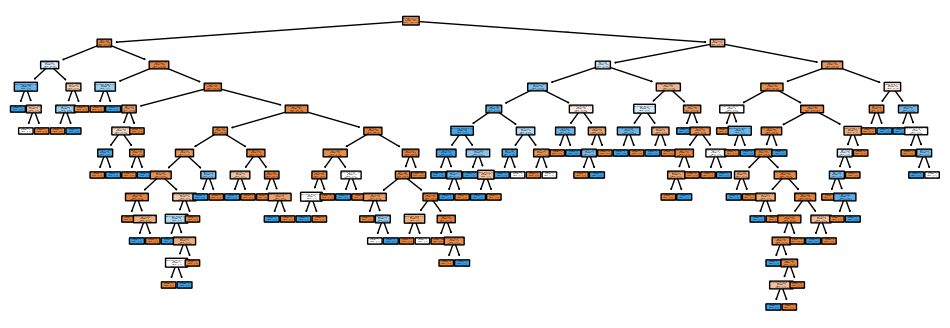

In [25]:
import matplotlib.pyplot as plt  # For plotting
from sklearn.tree import plot_tree  # For visualizing decision trees

# NOTE: We can plot the tree and it is huge!
plt.figure(figsize=(12, 4))
plot_tree(clf_dt,
          filled=True,
          rounded=True,
          class_names=["No Attrition", "Yes Attrition"],
          feature_names=X_encoded.columns)
plt.show()


##### Confusion Matrix

A confusion matrix is a table used to evaluate the performance of a classification model by comparing its predictions to the actual outcomes. It shows the counts of true positives, true negatives, false positives, and false negatives, providing insights into the model's accuracy, precision, recall, and other metrics.

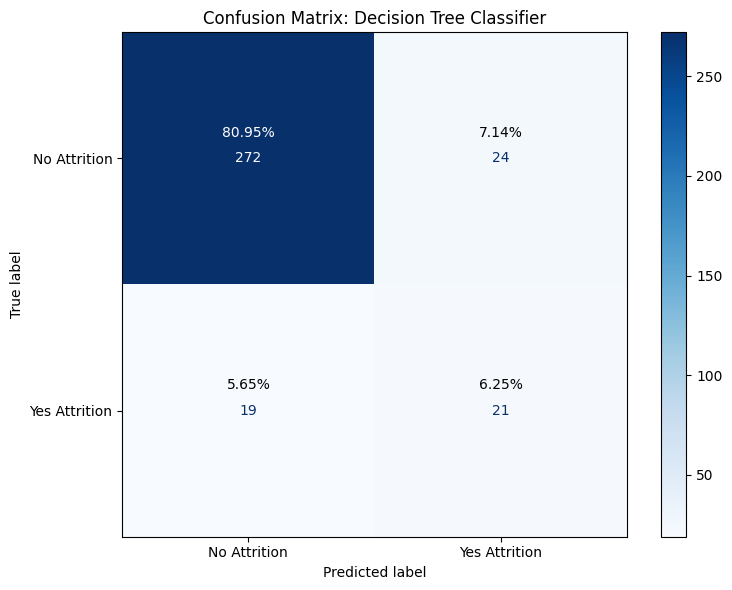

Plot saved as 'CrossVal_Orig.png'


In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Generate predictions using your trained model (assuming clf_dt is already defined)
y_pred = clf_dt.predict(X_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a figure for plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Plotting the Confusion Matrix with percentage annotations
cmd = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=["No Attrition", "Yes Attrition"])
cmd.plot(cmap=plt.cm.Blues, colorbar=True, ax=ax)

# Add percentage labels on top of each cell in the confusion matrix
total = cm.sum()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if total > 0:
            percent_text = f"{(cm[i, j] / total) * 100:.2f}%"
        else:
            percent_text = "0.00%"

        # Positioning text at center of each cell with proper formatting and adjusted positions
        ax.text(j, i - 0.1, percent_text,  # Adjust vertical position here (i - 0.1)
                ha='center', va='center', color='white' if cm[i, j] > total / 2 else 'black',
                fontsize=10)  # Adjust font size if needed

plt.title("Confusion Matrix: Decision Tree Classifier")
plt.tight_layout()  # Adjust layout to prevent labels from being cut off

# Save the plot directly using savefig
plt.savefig("CrossVal_Orig.png")  # Save the plot as an image
plt.show()

# Inform user about the saved plot
print("Plot saved as 'CrossVal_Orig.png'")


##### Cross Validation


Cross-validation accuracy provides an estimate of how well the model generalizes to unseen data by evaluating its performance on different subsets of the data.
----------------------------------------
Cross-validation scores: [0.80882353 0.82089552 0.86567164 0.85074627 0.86567164]
Mean CV accuracy: 0.8423617208077261
----------------------------------------

Performance Metrics:
----------------------------------------
Accuracy: 0.8423
Precision: 0.3617
Recall: 0.4250
F1-score: 0.3908
----------------------------------------

Accuracy: Measures the overall correctness of the model's predictions.
Precision: Out of all the positive predictions, how many were actually positive.
Recall: Out of all the actual positive cases, how many did the model correctly identify.
F1-score: A balanced measure considering both precision and recall.
----------------------------------------
----------------------------------------

The classification report provides a comprehensive evaluation of the model

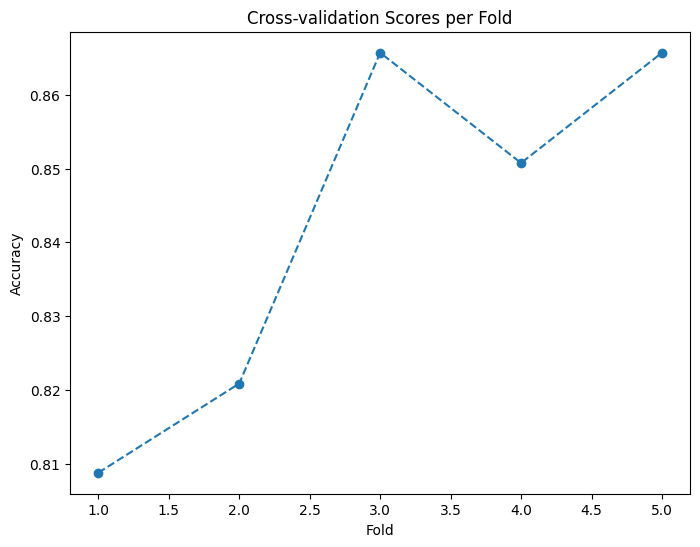

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


# Cross Validation
model = clf_dt  # Assuming 'clf_dt' is your trained DecisionTreeClassifier
X = X_test     # Assuming 'X_test' is your feature data for testing
y = y_test     # Assuming 'y_test' is your target variable data for testing
cv_folds = 5   # Number of cross-validation folds


# --- Cross-validation Scores ---
cv_scores = cross_val_score(model, X, y, cv=cv_folds)

print("\nCross-validation accuracy provides an estimate of how well the model generalizes to unseen data by evaluating its performance on different subsets of the data.")
print('-' * 40)
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())
print('-' * 40)

# --- Cross-validation Predictions ---
y_pred = cross_val_predict(model, X, y, cv=cv_folds)


# --- Performance Metrics ---
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)

print("\nPerformance Metrics:")
print('-' * 40)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print('-' * 40)
print("\nAccuracy: Measures the overall correctness of the model's predictions.")
print("Precision: Out of all the positive predictions, how many were actually positive.")
print("Recall: Out of all the actual positive cases, how many did the model correctly identify.")
print("F1-score: A balanced measure considering both precision and recall.")
print('-' * 40)

# --- Confusion Matrix ---
cm = confusion_matrix(y, y_pred)



print('-' * 40)



# --- Classification Report ---
print("\nThe classification report provides a comprehensive evaluation of the model's performance for each class, including precision, recall, F1-score, and support.")
print("\nClassification Report:")
print(classification_report(y, y_pred))
print('-' * 40)


# --- Visualizing Cross-validation Scores ---
print("\nThis plot visualizes the accuracy scores for each fold of cross-validation, providing insights into the model's consistency and stability across different data subsets.")

plt.figure(figsize=(8, 6))
plt.plot(range(1, cv_folds + 1), cv_scores, marker='o', linestyle='--')
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Cross-validation Scores per Fold")
plt.show()



##### Importance Matrix

Gini Importance (or Mean Decrease in Impurity):

Decision Trees use a metric called Gini Impurity to measure the disorder or uncertainty within a set of data.

When a tree is built, it aims to make splits that minimize this Gini Impurity, effectively creating more homogeneous subsets of data.

Feature importance is calculated by measuring how much each feature contributes to reducing the overall Gini Impurity of the tree.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances from the trained model
importances = clf_dt.feature_importances_

# Create a DataFrame to store feature importances
important_features = pd.DataFrame({
    'feature': X_train.columns,  # Assuming X_train contains your feature names
    'importance': importances
}).sort_values('importance', ascending=True)  # Sort in descending order

# Display the important features
#print("Important Features:")
#print(important_features)

# Plot feature importances
plt.figure(figsize=(5, 6))  # Adjust figure size if needed
plt.barh(important_features['feature'], important_features['importance'])
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.yticks(fontsize=5)  # Adjust the font size as needed
plt.show()

##### Feature Selection

Benefits of Removing Low-Importance Variables:

- **Improved Model Simplicity and Interpretability:** Removing irrelevant or redundant features makes the decision tree easier to understand and visualize.
- **Reduced Overfitting:** By focusing on the most important features, you can reduce the risk of the model overfitting to noise in the training data, leading to better generalization to unseen data.
- **Faster Training:** With fewer features to consider, the model can be trained more quickly.
- **Potential Performance Improvement:** In some cases, removing noisy or irrelevant features can slightly improve the model's predictive accuracy.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from IPython.display import display, Markdown

# Get feature importances from the trained model
importances = clf_dt.feature_importances_

# Create a DataFrame to store feature importances
important_features = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

# Filter out features with importance <= 0
filtered_features = important_features[important_features['importance'] > 0]['feature']

# *** Confirmation Method ***
# Create a Markdown string for the selected features
selected_features_md = "**Selected Features:**\n\n"
for feature in filtered_features.tolist():
    selected_features_md += f"- {feature}\n"

# Display the Markdown string using IPython.display.Markdown
display(Markdown(selected_features_md))

# Optionally, you can also print the number of selected features:
print(f"\nNumber of selected features: {len(filtered_features)}")

# Check if any important features were accidentally removed
if any(important_features[important_features['importance'] > 0.05]['feature'].isin(filtered_features) == False) :
  raise ValueError("Important Features Removed!!")

# Update X_train and X_test with selected features
X_train_filtered = X_train[filtered_features]
X_test_filtered = X_test[filtered_features]

bold text##### Re-iterate modeling and assessment

###### Filtered Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

## create a decisiont tree and fit it to the training data
clf_dt_filtered = DecisionTreeClassifier(random_state=373)


###### Fit Filtered Model

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Fit (train) the model
clf_dt_filtered.fit(X = X_train_filtered, y = y_train)

###### Filtered Cross Validation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)

# Assuming 'clf_dt_filtered' is a trained DecisionTreeClassifier
# Assuming 'X_test_filtered' is the feature test data and 'y_test' is the target test data

# Parameters
cv_folds = 5  # Number of cross-validation folds

# --- Cross-validation Scores ---
cv_scores = cross_val_score(clf_dt_filtered, X_test_filtered, y_test, cv=cv_folds)

print("\nCross-validation accuracy provides an estimate of how well the model generalizes to unseen data.")
print('-' * 40)
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())
print('-' * 40)

# --- Cross-validation Predictions ---
y_pred_cv = cross_val_predict(clf_dt_filtered, X_test_filtered, y_test, cv=cv_folds)

# --- Performance Metrics ---
accuracy = accuracy_score(y_test, y_pred_cv)
precision = precision_score(y_test, y_pred_cv, average='binary')
recall = recall_score(y_test, y_pred_cv, average='binary')
f1 = f1_score(y_test, y_pred_cv, average='binary')

print("\nPerformance Metrics:")
print('-' * 40)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print('-' * 40)

# --- Confusion Matrix ---
# Generate predictions for confusion matrix
y_pred_cm = clf_dt_filtered.predict(X_test_filtered)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_cm)

# Create a figure for plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Plotting the Confusion Matrix with percentage annotations
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Attrition", "Yes Attrition"])
cmd.plot(cmap=plt.cm.Blues, colorbar=True, ax=ax)

# Add percentage labels below each value in the confusion matrix
total = cm.sum()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value_text = f"{cm[i, j]}"
        percent_text = f"{(cm[i, j] / total) * 100:.2f}%" if total > 0 else "0.00%"
        ax.text(j, i, value_text, ha='center', va='center', color='white' if cm[i, j] > total / 2 else 'black')
        ax.text(j, i + 0.2, percent_text, ha='center', va='center', fontsize=9, color='black')

plt.title("Confusion Matrix: Decision Tree Classifier")
plt.tight_layout()
plt.show()

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred_cm))
print('-' * 40)

# --- Visualizing Cross-validation Scores ---
plt.figure(figsize=(8, 6))
plt.plot(range(1, cv_folds + 1), cv_scores, marker='o', linestyle='--')
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Cross-validation Scores per Fold")
plt.show()


#### Hyper-parameter Tuning

##### Gridsearch

GridSearch is a technique in machine learning and statistical modeling used to tune hyperparameters of a model. It systematically evaluates a range of hyperparameter combinations to identify the best set of parameters that optimize a model's performance. This is particularly useful for improving the accuracy and generalization of predictive models.

In [ ]:
# Initial Parameter grid tuning, default settings
param_grid = {
    'criterion': ['gini', 'entropy'],  # The function to measure the quality of a split. Supported criteria are "gini" for the Gini impurity and "entropy" for the information gain.
    #'splitter': ['best', 'random'],  # The strategy used to choose the split at each node. Supported strategies are "best" to choose the best split and "random" to choose the best random split.
    'max_depth': [None, 5, 10, 15, 20, 30, 40, 50],  # The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
    'min_samples_split': [2, 5, 10, 20, 50, 100],  # The minimum number of samples required to split an internal node.
    #'min_samples_leaf': [1, 2, 4, 8, 20, 50],  # The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.
    #'min_weight_fraction_leaf': [0.0, 0.01, 0.05, 0.1],  # The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.
    #'max_features': ['auto', 'sqrt', 'log2', None],  # The number of features to consider when looking for the best split:
                                                    # - 'auto': This is equivalent to 'sqrt' (see below).
                                                    # - 'sqrt': This will use the square root of the total number of features at each split. For example, if you have 16 features, it will consider 4 features at each split (sqrt(16) = 4).
                                                    # - 'log2': This will use the base-2 logarithm of the total number of features at each split. For example, if you have 16 features, it will consider 4 features at each split (log2(16) = 4).
    #'max_leaf_nodes': [None, 10, 20, 50, 100],  # Grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
    'min_impurity_decrease': [0.0, 0.001, 0.01, 0.1]#,  # A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
    #'class_weight': [None, 'balanced'],  # Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one. For multi-output problems, a list of dicts can be provided in the same order as the columns of y.
                                          # - The "balanced" mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).
                                          # - Note that these weights will be multiplied with sample_weight (passed through the fit method) if sample_weight is specified.
    #'ccp_alpha': [0.0, 0.01, 0.1, 1.0],  # Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen. By default, no pruning is performed. See Minimal Cost-Complexity Pruning for details.
}

cv_folds = 5  # Number of folds

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# GridSearchCV
gridSearch = GridSearchCV(
    estimator=clf_dt_filtered,         # Model to optimize
    param_grid=param_grid,    # Parameter grid
    cv=cv_folds,                     # Number of cross-validation folds
    scoring='accuracy',       # Scoring metric (can be adjusted)
    verbose=1                 # Print progress during search
)

# Fit GridSearchCV to the training data
gridSearch.fit(X_train_filtered, y_train)

# Print best parameters and best score
print('Best score: ', gridSearch.best_score_)
print('Best parameters: ', gridSearch.best_params_)

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Get the best decision tree model from GridSearchCV
best_clf = gridSearch.best_estimator_

# Plot the decision tree
plt.figure(figsize=(20, 10))  # Adjust the size for better visibility
plot_tree(
    best_clf,
    feature_names=X_train_filtered.columns,  # Replace with actual feature names
    class_names=["No Attrition", "Yes Attrition"],  # Replace with actual class names
    filled=True,                     # Color the nodes based on class distribution
    rounded=True                     # Rounded corners for better readability
)

plt.title("Initial Decision Tree Visualization", fontsize=16)
plt.show()

##### Cross Validation

Cross-validation is a statistical technique used in machine learning to assess how well a model generalizes to unseen data. It divides the dataset into multiple subsets (or folds) and iteratively trains and evaluates the model on different splits of the data. This ensures that the model is tested on data it hasn't seen during training, which provides a robust estimate of its performance.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


# Cross Validation
model = clf_dt_filtered  # Assuming 'clf_dt' is your trained DecisionTreeClassifier
X = X_test_filtered     # Assuming 'X_test' is your feature data for testing
y = y_test     # Assuming 'y_test' is your target variable data for testing
cv_folds = 5   # Number of cross-validation folds


# --- Cross-validation Scores ---
cv_scores = cross_val_score(model, X, y, cv=cv_folds)

print("\nCross-validation accuracy provides an estimate of how well the model generalizes to unseen data by evaluating its performance on different subsets of the data.")
print('-' * 40)
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())
print('-' * 40)

# --- Cross-validation Predictions ---
y_pred = cross_val_predict(model, X, y, cv=cv_folds)


# --- Performance Metrics ---
#accuracy = accuracy_score(y, y_pred)
#precision = precision_score(y, y_pred)
#recall = recall_score(y, y_pred)
#f1 = f1_score(y, y_pred)

#print("\nPerformance Metrics:")
#print('-' * 40)
#print(f"Accuracy: {accuracy:.4f}")
#print(f"Precision: {precision:.4f}")
#print(f"Recall: {recall:.4f}")
#print(f"F1-score: {f1:.4f}")
#print('-' * 40)
#print("\nAccuracy: Measures the overall correctness of the model's predictions.")
#print("Precision: Out of all the positive predictions, how many were actually positive.")
#print("Recall: Out of all the actual positive cases, how many did the model correctly identify.")
#print("F1-score: A balanced measure considering both precision and recall.")
#print('-' * 40)

# --- Confusion Matrix ---
cm = confusion_matrix(y, y_pred)

print("\nThe confusion matrix provides a detailed breakdown of the model's predictions, showing the counts of true positives, true negatives, false positives, and false negatives.")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
print('-' * 40)

# --- Visualizing Cross-validation Scores ---
print("\nThis plot visualizes the accuracy scores for each fold of cross-validation, providing insights into the model's consistency and stability across different data subsets.")

plt.figure(figsize=(8, 6))
plt.plot(range(1, cv_folds + 1), cv_scores, marker='o', linestyle='--')
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Cross-validation Scores per Fold")
plt.show()
print('-' * 40)

# --- Classification Report ---
print("\nThe classification report provides a comprehensive evaluation of the model's performance for each class, including precision, recall, F1-score, and support.")
print("\nClassification Report:")
print(classification_report(y, y_pred))
print('-' * 40)
print("\nAccuracy: Measures the overall correctness of the model's predictions.")
print("Precision: Out of all the positive predictions, how many were actually positive.")
print("Recall: Out of all the actual positive cases, how many did the model correctly identify.")
print("F1-score: A balanced measure considering both precision and recall.")
print('-' * 40)





In [ ]:
# Re-Print best parameters and best score
print('Original Model - Best Results')
print('-' * 40)
print('Best score: ', gridSearch.best_score_)
print('Best parameters: ', gridSearch.best_params_)

In [ ]:
# Initial Parameter grid tuning
# For reference, don't change

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20, 30, 40, 50],
    'min_impurity_decrease': [0.0, 0.001, 0.01, 0.1],
    'min_samples_split': [2, 5, 10, 20, 50, 100],
}

cv_folds = 5

In [ ]:
# Updated param_grid
param_grid = {
        'criterion': ['entropy'],
        'max_depth': [5],
        'min_impurity_decrease': [0.0001],
        'min_samples_split': [100]  # Updated values
    }

# Re-run GridSearchCV
gridSearch = GridSearchCV(clf_dt_filtered, param_grid, cv=cv_folds)
gridSearch.fit(X_train_filtered, y_train)

# Print best parameters and best score
print('Best score: ', gridSearch.best_score_)
print('Best parameters: ', gridSearch.best_params_)

In [ ]:
# Evaluate the final model on validatoipn data
best_clf = gridSearch.best_estimator_
y_pred = best_clf.predict(X_test_filtered)
valid_accuracy = best_clf.score(X_test_filtered, y_test)

print("Accuracy on validation set:", valid_accuracy)

## Stage 5: Evaluation

### Final Model

#### Final Decision Tree Plot

In [ ]:
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    best_clf,
    feature_names=X_train_filtered.columns,  # Replace with your actual feature names
    class_names=best_clf.classes_.astype(str),  # Replace with your class names if available
    filled=True,  # Color the nodes
    rounded=True  # Rounded corners for readability
)
plt.title("Decision Tree Visualization", fontsize=16)
plt.show()

#### Final Confusion Matrix

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Calculate percentages

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_clf.classes_)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)

# Annotate percentages below the values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i + 0.2, f"{normalized_cm[i, j]:.1f}%", ha="center", va="center", fontsize=10, color="black")

plt.title("Confusion Matrix with Percentages")
plt.show()


#### Final Cross Validation Report

In [ ]:
# --- Classification Report ---
print("\nThe classification report provides a comprehensive evaluation of the model's performance for each class, including precision, recall, F1-score, and support.")
print("\nClassification Report:")
print(classification_report(y, y_pred))
print('-' * 40)
print("\nAccuracy: Measures the overall correctness of the model's predictions.")
print("Precision: Out of all the positive predictions, how many were actually positive.")
print("Recall: Out of all the actual positive cases, how many did the model correctly identify.")
print("F1-score: A balanced measure considering both precision and recall.")
print('-' * 40)


## Stage 6: Deploy

So that's it!

Let's review what we have done:

 1. Collected some data
 2. Reviewed, cleaned, shaped, and transformed the data
 3. Built the Decision Classifier Tree model
 4. Tested the model on increasingly fine tuned parameters
 5. Produced the final model!

Now we will deploy this model to a web app

# Conclusion